In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score
from plotly.subplots import make_subplots

In [62]:
# Load and clean data
data = pd.read_csv('Churn_Modelling.csv')


In [63]:
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [64]:
data_cleaned = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
X = data_cleaned.drop('Exited', axis=1)
y = data_cleaned['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [65]:
# Define preprocessing pipelines
numeric_features = X.select_dtypes(exclude=['object']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


In [66]:
# Train models
model_lr = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(max_iter=1000))])
model_rf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])
model_gb = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', GradientBoostingClassifier(random_state=42))])

model_lr.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_gb.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)
y_pred_rf = model_rf.predict(X_test)
y_pred_gb = model_gb.predict(X_test)


In [67]:
# Save results
results = pd.DataFrame({
    'CustomerID': data.loc[X_test.index, 'CustomerId'],
    'Actual': y_test,
    'Logistic_Regression_Prediction': y_pred_lr,
    'Random_Forest_Prediction': y_pred_rf,
    'Gradient_Boosting_Prediction': y_pred_gb
})

results.to_csv('churn_predictions.csv', index=False)
print(f"Gradient Boosting Classification Report:\n{classification_report(y_test, y_pred_gb)}")

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.78      0.49      0.61       407

    accuracy                           0.87      2000
   macro avg       0.83      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



In [68]:
def plot_gauge_chart(y_test, y_pred_lr, y_pred_rf, y_pred_gb):
    models = {
        'Logistic Regression': accuracy_score(y_test, y_pred_lr),
        'Random Forest': accuracy_score(y_test, y_pred_rf),
        'Gradient Boosting': accuracy_score(y_test, y_pred_gb)
    }

    fig = make_subplots(rows=1, cols=len(models), specs=[[{'type': 'indicator'}] * len(models)])

    for i, (model, accuracy) in enumerate(models.items()):
        fig.add_trace(go.Indicator(
            mode="gauge+number",
            value=accuracy * 100,
            title={'text': f'{model} Accuracy'},
            gauge={'axis': {'range': [0, 100]},
                   'bar': {'color': "blue"},
                   'steps': [{'range': [0, 100], 'color': "lightgray"}],
                   'threshold': {'line': {'color': "red", 'width': 4},
                                 'thickness': 0.75,
                                 'value': accuracy * 100}}),
            row=1, col=i+1
        )

    fig.update_layout(
        title="Model Accuracy Gauge Charts",
        showlegend=False
    )

    fig.show()

# Call the function with your predictions and true labels
plot_gauge_chart(y_test, y_pred_lr, y_pred_rf, y_pred_gb)

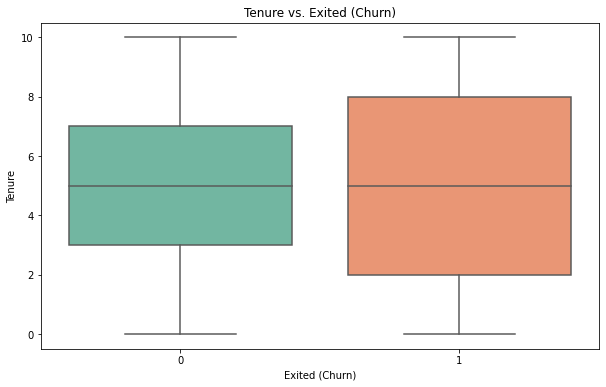

In [69]:
def plot_tenure_vs_exited(data_cleaned):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Exited', y='Tenure', data=data_cleaned, palette='Set2')
    plt.title('Tenure vs. Exited (Churn)')
    plt.xlabel('Exited (Churn)')
    plt.ylabel('Tenure')
    plt.show()

# Call the function
plot_tenure_vs_exited(data_cleaned)

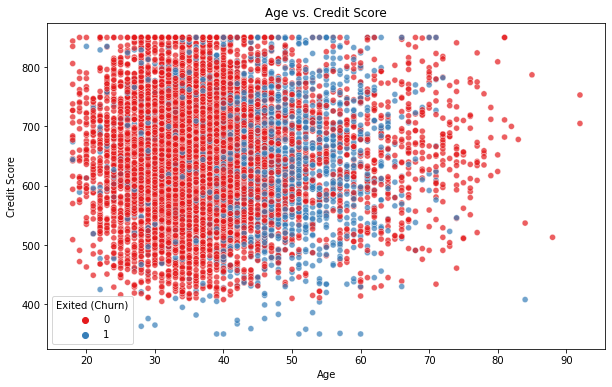

In [72]:
def plot_age_vs_credit_score(data_cleaned):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Age', y='CreditScore', data=data_cleaned, hue='Exited', palette='Set1', alpha=0.7)
    plt.title('Age vs. Credit Score')
    plt.xlabel('Age')
    plt.ylabel('Credit Score')
    plt.legend(title='Exited (Churn)')
    plt.show()

# Call the function
plot_age_vs_credit_score(data_cleaned)